# Final project: Stock Prediction

Given the recent stock market history, you will predict the return for ticker AAPL for the day ahead.

# Objectives

You will demonstrate your strengths in several areas, especially
- Exploratory Data Analysis
- Feature Engineering
- Creating, testing and evaluating models
- Error analysis
and Prediction **using Neural Networks**.

Your objective will be to predict next period price returns of a stock given its past prices.

**To be precise**
- given recent prices for AAPL you will predict the next *return*
- *return* will be defined precisely below
- you will be evaluated on a holdout data directory
    - it will have 2 years of data
    - you will be required to predict next period returns for the final 200 days
    - when making a prediction for date $t$, where $t$ is in the holdout data range (**beyond** the last training date)
        - you may use *actual* holdout data for dates strictlty prior to date $t$
        - That is: your prediction for date $t$ *does not* need to be dependent on your *prediction* for date $(t-1)$
    

**Predicting forward returns/prices is hard ! If you could do it well: you would be rich**

Given that fact, out of sample performance will **not** be the sole metric for your grade

This project will test your ability to analyze data, create hypotheses, test them, and improve through iteration.

**You will learn a lot, especially from failures**

This project provides a wealth of opportunity for
- Exploratory data analysis
    - This can suggest several different approaches to building one or more models
- Error Analysis
- Creating, and evaluating models iteratively, learning from past failures and successes.

So your performance will be based on your creativity and experimental process, even if the process
does not lead to great out of sample performance

# The data

As explained in the Final Project Overview:
- you will be given a data directory for training
    - supplied as a compressed archive file in the course's Resource tab in NYU Classes
    - unpacking this file will yield directory `./Data/train`

The data directory will contain one file per ticker, with a history going back many years of fields including
- Price: Close, Open, High, Low
- Volume

"return" means the percent change in the **Close** feature

You will need to 
- decide which files and which fields to use
- prepare the data for training and testing
    - convert from price to return as necessary
    - prepare train and test examples:
    

## Data preparation

- The files contain prices; your goal is to predict a *return* not a price
- Your goal is to predict the **percent change of the Close feature** ("return")
- Your predicted return for day $t$ should be a function of data occuring *before* day $t$

So your first step will be to create a suitable training set.

For example, the following training set is a good starting point:
- each row is an example
- each row will have a column `Dt` indicating time $t$
- each example has *at least* 20 features
    - derived from AAPL features occuring *before* time $t$
- the target for the row with time $t$ should be the *return* of AAPL for date $t$
    - i.e., the percent price change of AAPL from time $t-1$ to time $t$



# Out of sample evaluation

*You* should test your models out of sample.

This will be beneficial as *we* will evaluate your model out of sample using a holdout data directory.

The *holdout data directory* will be for dates that are strictly later than the latest date in the
training data directory.
- will contain 2 years of data
- you will be required to predict the latest 200 returns of AAPL for this holdout directory
- your submission *must work on the holdout directory*
    - you should assume the directory is at relative path  `./data/holdout`

So you might want to create your own validation/test data (from the training data directory) that mimics
what the holdout data directory will contain.

It is up to you to decide on the out of sample data that you use for model development.


# Suggestions for  getting started

The problem we presented to you is unstructured and not precisely defined in full detail.

- Start by defining, in detail,  the problem that you will attempt to solve
    - Do you view this as a Regression task ?  A Classification task
    - Justify your choice
~ Define the Performance Metric that you think is appropriate
    - Justify your choice

- Start with a simple model, using only data from AAPL (few features)
    - Use the model to get a feel for the problem
    - Will be a good baseline
    - Will help you form new hypotheses to test
        - may guide the choice of additional features
- Create new models iteratively
    - Train and evaluate a "simpler" model
    - Evalute performance
    - Perform error analysis
    - Propose a new "less simple" model
        - add as many features as you like, from any file in the directory

- Be disciplined in your process: avoid repeating code
    - It will be easier if you have a single piece of code that works for
        - the training directory
        - the test directory (that you might choose to create)
        - the holdout directory
    - This will
        - simplify your process
        - help ensure that your submission will work on the holdout directory !
   

# Warning: Avoid looking into the future !

Obviously, you should not use knowledge of the future to predict future prices.

But it is surprisingly easy to inadvertantly do so !  For example:
- when standardizing a data set: you might compute averages and standard deviations over the full range of dates
    - this means that the earliest dates have implicit knowledge of later dates
        - for example, suppose the mean increases after 10 days
        - the observations of the first 9 days *should not know* that the mean of the entire data range is different than what is available from earlier observations

# Evaluating your model
   
Your goals
- demonstrate that your models can predict in-sample (based on training only) somewhat successfully
    - this is easier than predicting out of sample
    - this will show that your model has "learned" something
- evaluate your model out of sample using the validation/test set you created
- run multiple experiments to try to improve out of sample prediction
- present a "final model" which we will evaluate with a holdout dataset
     - The holdut dataset will be identical in structure to the full data set we provide
     - *BUT* the dates will be strictly after the dates in the full dataset.

# Final reminder: document your thought process

**The key to getting a good grade** is to
- document everything you do
- justify the many choices you will have to make -- use data and intuition to back up your statements
- report on failed theories/experiments
    - it shows the amount of effort you expended
    - tell us
        - why you thought it was a good idea to try
        - what you learned from the failure
        - how the failure led you to try something different
        
The out of sample prediction is hard -- you may or may not do well.

What is important is to see how you tried to improve and how failure as well as success led to
better experiments.

In [572]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [2]:
aapl = pd.read_csv('data/train/AAPL.csv')  

## Have a look at the data

In [3]:
aapl.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0


In [4]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dt         4277 non-null   object 
 1   Adj Close  4277 non-null   float64
 2   Close      4277 non-null   float64
 3   Div        4277 non-null   float64
 4   Factor     4277 non-null   float64
 5   High       4277 non-null   float64
 6   Low        4277 non-null   float64
 7   Open       4277 non-null   float64
 8   Volume     4277 non-null   float64
dtypes: float64(8), object(1)
memory usage: 300.9+ KB


In [5]:
aapl.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03
mean,34.065846,170.450354,0.001999,1.001870,172.424040,168.407568,170.528689,1.299660e+08
std,36.698987,173.484604,0.031011,0.094251,174.989551,171.934671,173.604272,9.970883e+07
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06
25%,3.115300,39.759000,0.000000,1.000000,40.260000,39.030000,39.530000,6.363350e+07
50%,16.948300,106.745000,0.000000,1.000000,108.360000,105.200000,106.959000,1.016484e+08
75%,62.413600,222.250000,0.000000,1.000000,224.980000,217.890000,220.010000,1.679636e+08
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09


Fortunately, there is no Nan yet. But it is worth noticing that AAPL is such a long standing stock that there are lots of company actions that affect the stock price and yield dividend. So Ajusted Close would be a better variable for our baseline model.

## Plot data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4630f89d0>,
      dtype=object)

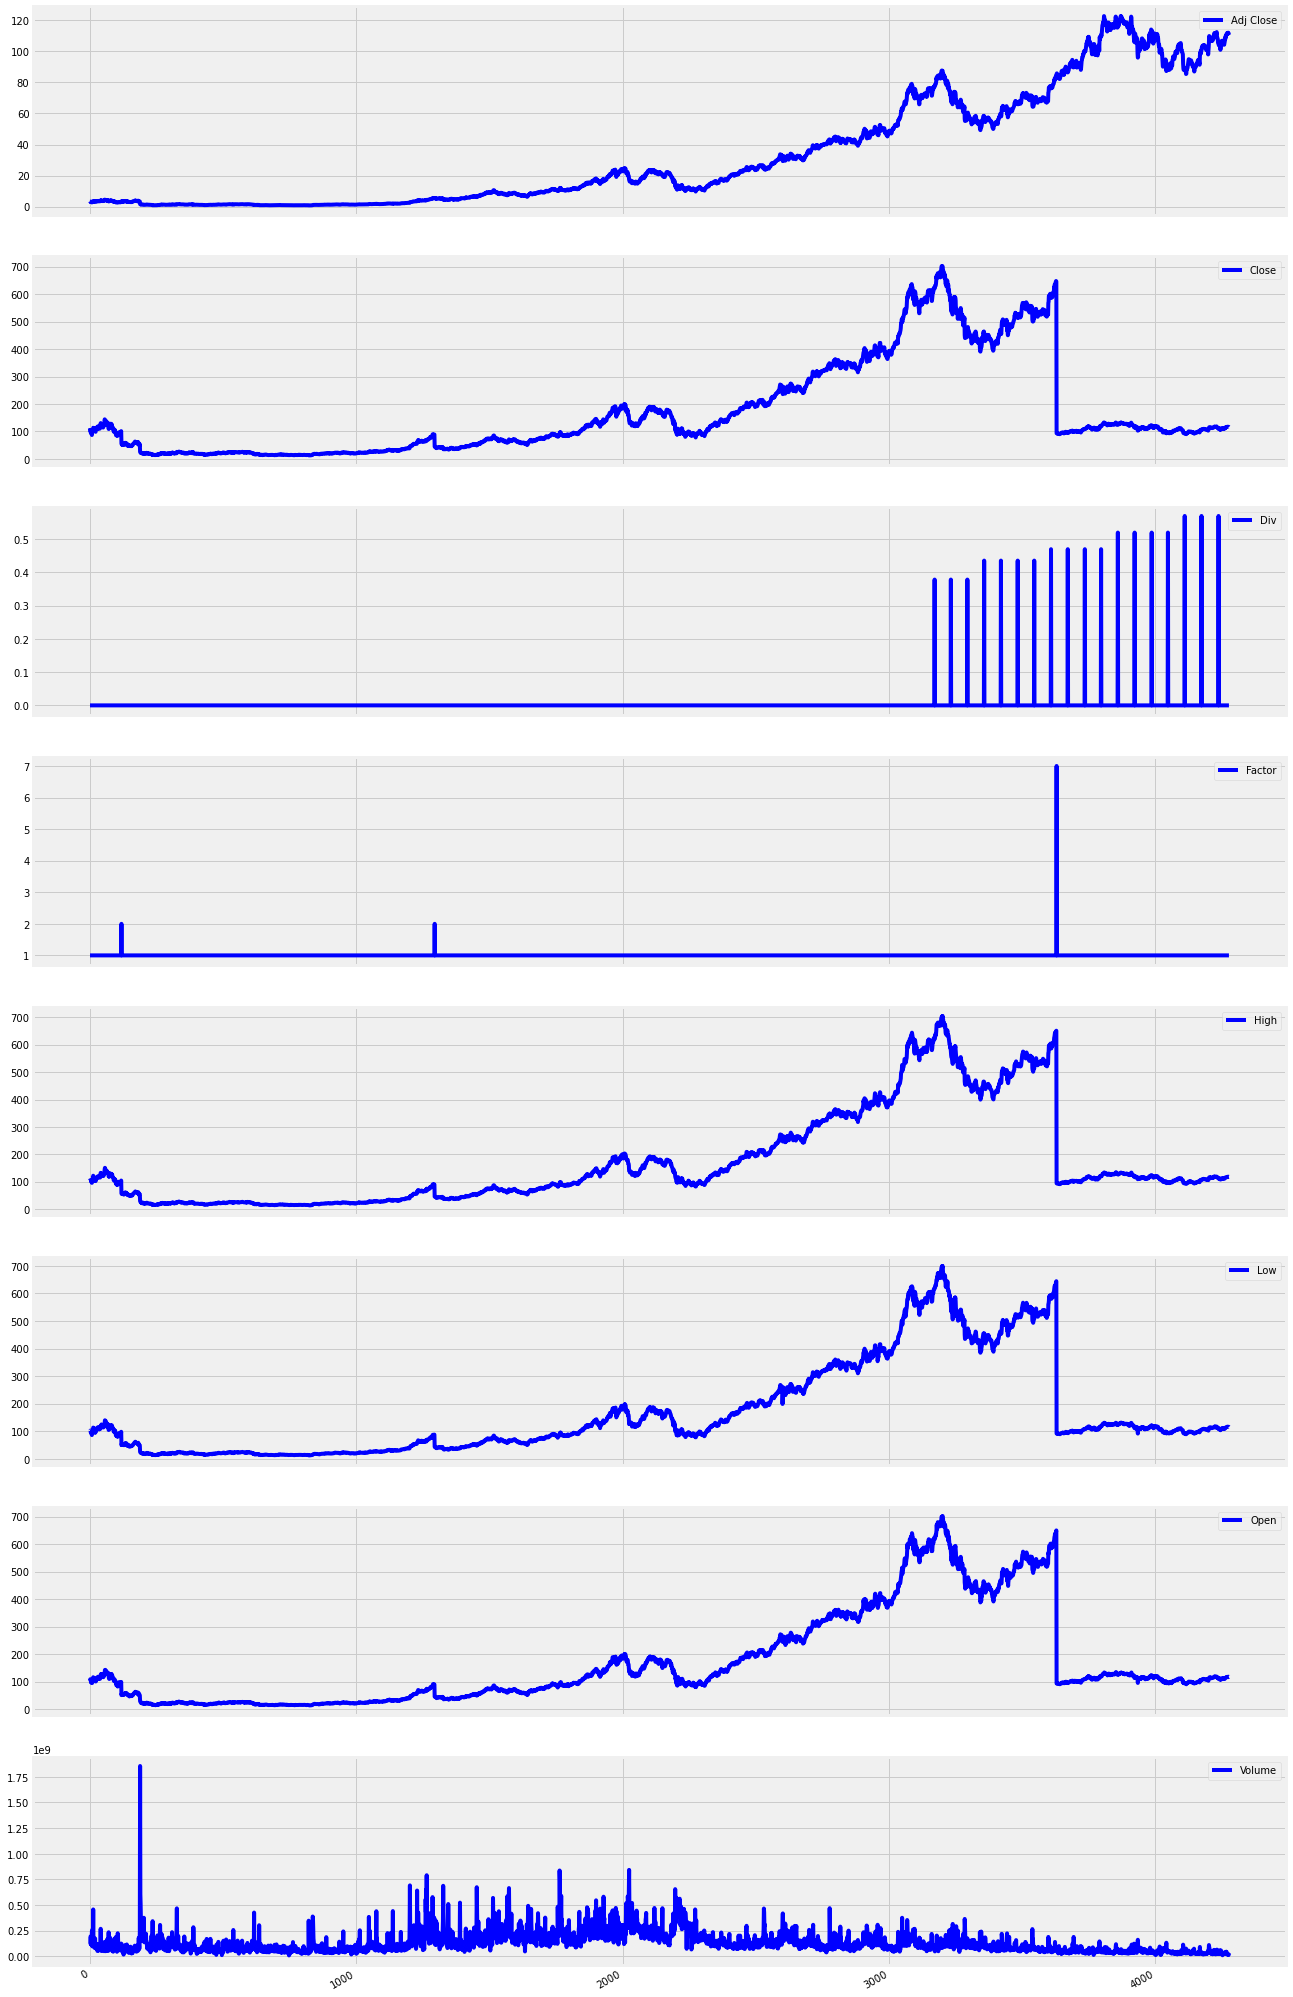

In [6]:
aapl.iloc[:,1:9].plot(subplots = True, color = 'blue',grid = True, figsize = (20,40))

## Calculate the return

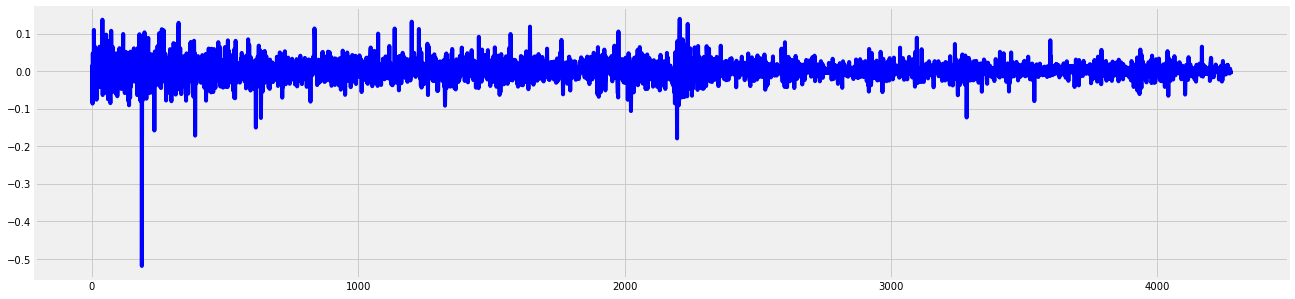

In [7]:
aapl["Return"] = aapl["Adj Close"].pct_change()
aapl["Return"].plot(color = 'blue',grid = True, figsize = (20,5))

Let's get the histogram of daily return.

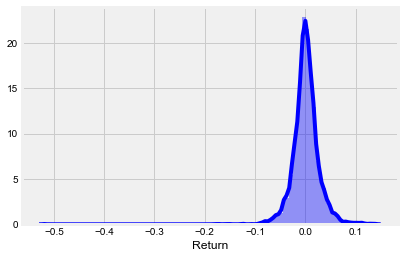

In [8]:
sns.distplot(aapl["Return"], bins=100, color = 'blue')
sns.set_style('whitegrid')


As we can see, the distribution of daily return has a long left tail. Plus, the data is crowded in the range(-0.1, 0.1). Hence, a scaling or normalization is needed.

Calculate the cummulative return. It is also worth thinking whether we should use the cummulative return as the variable or just the return. Firstly, I will try the raw return, which is simply (adjusted close(t) - adjusted close(t-1))/ ajusted close(t-1).

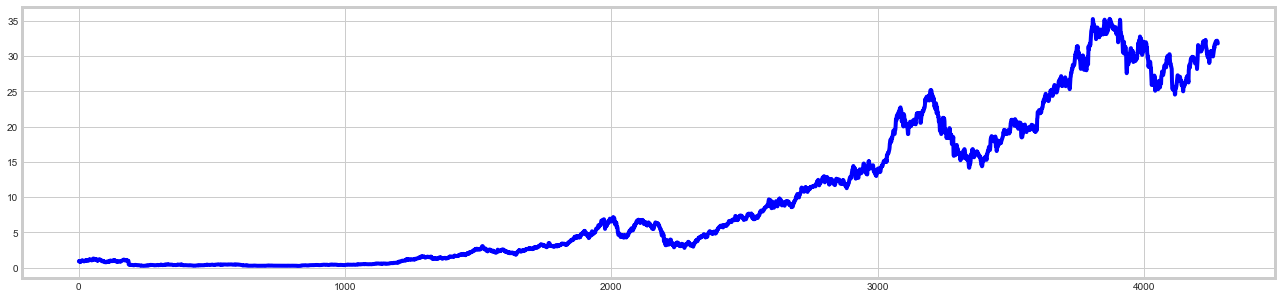

In [9]:
aapl["Cumreturn"] = aapl["Return"]+1
aapl["Cumreturn"] = aapl["Cumreturn"].cumprod()
aapl["Cumreturn"].plot(color = 'blue',grid = True, figsize = (20,5))

## Analyzing data and finding useful features

Even though it may be wrong about "The more the better" in machine learning, a teaspoon of features is not enough. Especially when we are forecasting the return of a single stock, the impact that similar stocks and market trend exerts cannot be overlooked. Thus, let us find out what is in our data file. Since some of the companies or indexes are not listed from 2000, we manually select the integral data to analyze.

Start import data and calculate the daily return of each stock.

AAPL: Apple Inc<br>
ADBE: Adobe Inc<br>
CSCO: CISCO<br>
IBM:  IBM<br>
MSFT: Microsoft<br>
NVDA: NIVIDA<br>
SPY:  SPDR S&P 500 ETF<br>
XLB:  Materials Select Sector SPDR Fund<br>
XLE:  Energy Select Sector SPDR Fund<br>
XLF:  Financial Select Sector SPDR Fund<br>
XLK:  Technology Select Sector SPDR Fund<br>
XLP:  Consumer Staples Select Sector SPDR Fund<br>
XLU:  Utilities Select Sector SPDR Fund<br>
XLV:  Health Care Select Sector SPDR Fund<br>
XLY:  Consumer Discretionary Select Sector SPDR Fund<br>

In [134]:
def generate_return(name):
    path = 'data/train/'+name+'.csv'
    data = pd.read_csv(path)
    data["Return"] = data["Adj Close"].pct_change()
    return data["Return"]

In [135]:
name_list = ["ADBE","CSCO","IBM","MSFT","NVDA","SPY","XLB","XLE","XLF","XLK","XLP","XLU","XLV","XLY"]
data = aapl.copy()
for name in name_list:
    data[name] = generate_return(name)


Great, right now we create a DataFrame containing all the information in AAPL as well as the daily return of all other stocks. Let's look at the data and find if there are some interesting relations between the apple stock and the rest of it.

In [136]:
data.drop(['Cumreturn'],axis=1,inplace=True)
data.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,...,NVDA,SPY,XLB,XLE,XLF,XLK,XLP,XLU,XLV,XLY
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318,...,-0.026702,-0.039106,-0.009628,-0.018826,-0.043724,-0.050733,-0.028157,-0.030159,-0.022693,-0.030081
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630,...,-0.032922,0.001789,0.041312,0.026380,-0.007850,-0.014847,0.017670,0.025230,-0.008971,-0.012301
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546,...,-0.065248,-0.016071,0.025672,0.038550,0.043918,-0.033150,0.018751,-0.001714,0.003194,0.011370
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390,...,0.016692,0.058076,-0.000568,0.010688,0.016543,0.017455,0.063395,0.008598,0.012207,0.047108


In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dt         4277 non-null   object 
 1   Adj Close  4277 non-null   float64
 2   Close      4277 non-null   float64
 3   Div        4277 non-null   float64
 4   Factor     4277 non-null   float64
 5   High       4277 non-null   float64
 6   Low        4277 non-null   float64
 7   Open       4277 non-null   float64
 8   Volume     4277 non-null   float64
 9   Return     4276 non-null   float64
 10  ADBE       4276 non-null   float64
 11  CSCO       4276 non-null   float64
 12  IBM        4276 non-null   float64
 13  MSFT       4276 non-null   float64
 14  NVDA       4276 non-null   float64
 15  SPY        4276 non-null   float64
 16  XLB        4276 non-null   float64
 17  XLE        4276 non-null   float64
 18  XLF        4276 non-null   float64
 19  XLK        4276 non-null   float64
 20  XLP     

In [138]:
data.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,ADBE,...,NVDA,SPY,XLB,XLE,XLF,XLK,XLP,XLU,XLV,XLY
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03,4276.000000,4276.000000,...,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000
mean,34.065846,170.450354,0.001999,1.001870,172.424040,168.407568,170.528689,1.299660e+08,0.001186,0.000844,...,0.001578,0.000253,0.000369,0.000472,0.000396,0.000151,0.000325,0.000351,0.000315,0.000384
std,36.698987,173.484604,0.031011,0.094251,174.989551,171.934671,173.604272,9.970883e+07,0.026760,0.028672,...,0.039834,0.012509,0.015708,0.017697,0.020196,0.016533,0.009421,0.012075,0.011543,0.014350
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06,-0.518677,-0.297583,...,-0.352344,-0.098448,-0.124122,-0.144437,-0.166664,-0.086536,-0.060240,-0.085290,-0.097825,-0.116250
25%,3.115300,39.759000,0.000000,1.000000,40.260000,39.030000,39.530000,6.363350e+07,-0.011262,-0.011706,...,-0.016568,-0.005133,-0.007343,-0.008259,-0.007133,-0.006905,-0.004505,-0.005378,-0.005329,-0.006269
50%,16.948300,106.745000,0.000000,1.000000,108.360000,105.200000,106.959000,1.016484e+08,0.000806,0.000471,...,0.000585,0.000649,0.000794,0.000759,0.000490,0.000786,0.000477,0.000943,0.000551,0.000631
75%,62.413600,222.250000,0.000000,1.000000,224.980000,217.890000,220.010000,1.679636e+08,0.013808,0.012632,...,0.017401,0.005950,0.008525,0.009942,0.007966,0.007345,0.005291,0.006735,0.006341,0.007518
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09,0.139042,0.239720,...,0.424168,0.145198,0.140576,0.164745,0.309680,0.161019,0.068856,0.120731,0.120545,0.097755


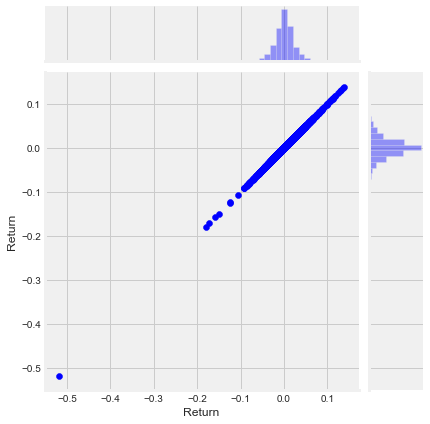

In [139]:
sns.jointplot('Return', 'Return', data, kind='scatter', color = 'blue')

The max drawdown of return is so obvious and it just happens one time in these 20 years. SO I decide to drop this row in order to improve our model performance.

And we find the correlations again.

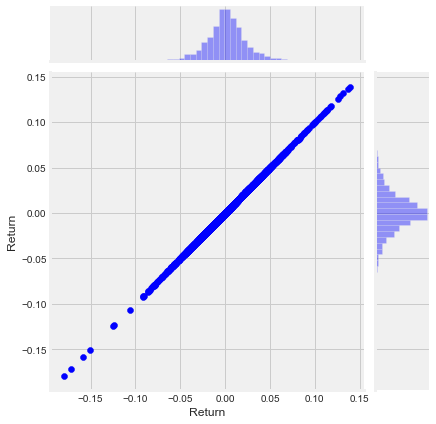

In [140]:
down_row = data[data.Return == data.Return.min()].index[0]
data.drop([down_row], inplace=True)
sns.jointplot('Return', 'Return', data, kind='scatter', color = 'blue')

Text(0.5, 1.0, 'XLK')

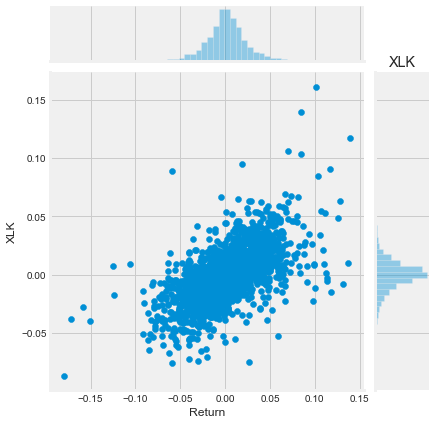

In [141]:
sns.jointplot(x='Return', y='XLK', data=data, kind='scatter')
plt.title('XLK')

Text(0.5, 1.0, 'XLE')

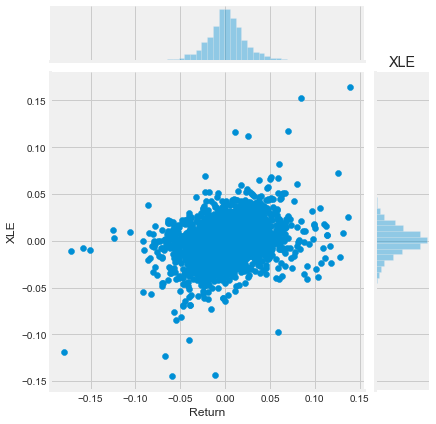

In [142]:
sns.jointplot('Return', 'XLE', data, kind='scatter')
plt.title('XLE')

In [143]:
data[['Return','XLK','XLE']].corr()

,Return,XLK,XLE
Return,1.00000,0.623650,0.314260
XLK,0.62365,1.000000,0.475736
XLE,0.31426,0.475736,1.000000


As we can there are some correlations between different kind of stocks. We should consider them one of our features. Let's visualize the full map of the correlation.

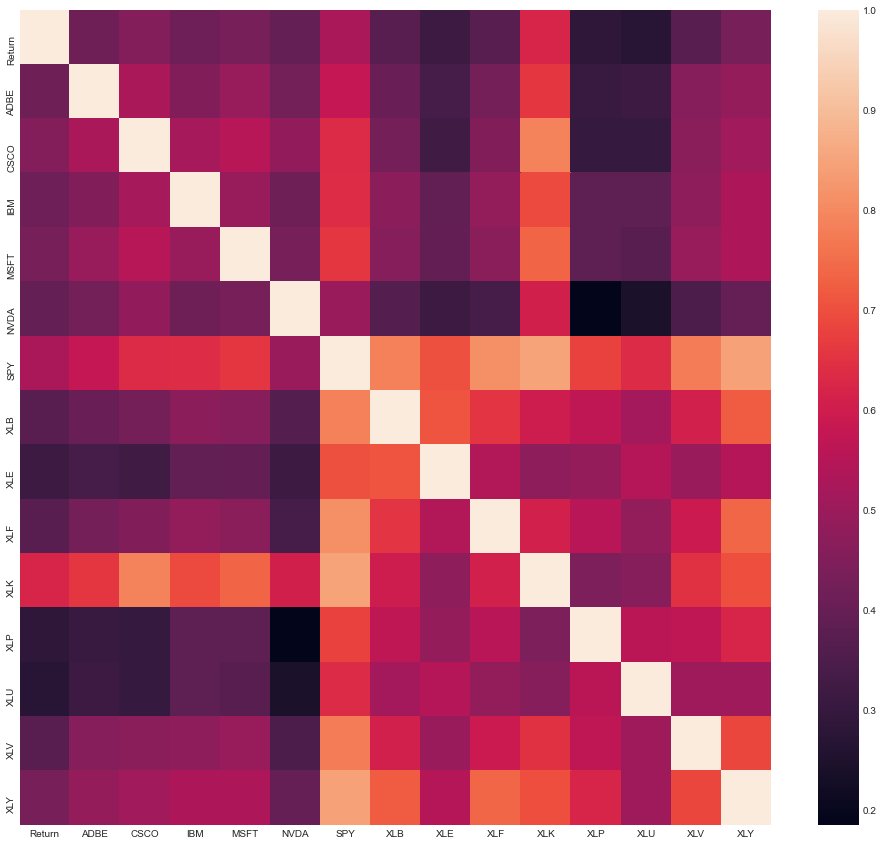

In [144]:
plt.figure(figsize=(15,15))
sns.heatmap(data.iloc[:,9:24].corr())

As we can see, the AAPL daily return has kind of strong relation with SPY and XLK. I decide to drop the rest first and see what's going on.

In [145]:
data1 = data.iloc[:,0:10].copy()
data1['SPY'] = data['SPY']
data1['XLK'] = data['XLK']
data1.drop(0,inplace=True)

In [146]:
data1.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,SPY,XLK
count,4275.000000,4275.000000,4275.000000,4275.000000,4275.000000,4275.000000,4275.000000,4.275000e+03,4275.000000,4275.000000,4275.000000
mean,34.080595,170.497889,0.002000,1.001871,172.471606,168.456633,170.577343,1.295614e+08,0.001307,0.000255,0.000161
std,36.701228,173.508758,0.031018,0.094273,175.014333,171.957942,173.628324,9.617568e+07,0.025554,0.012509,0.016521
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06,-0.179195,-0.098448,-0.086536
25%,3.118200,39.759500,0.000000,1.000000,40.270000,39.065000,39.540000,6.357365e+07,-0.011244,-0.005129,-0.006880
50%,16.949600,106.745000,0.000000,1.000000,108.360000,105.210000,106.960000,1.016190e+08,0.000810,0.000649,0.000796
75%,62.419200,222.635000,0.000000,1.000000,224.990000,218.070000,220.240000,1.679356e+08,0.013811,0.005952,0.007349
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,8.432424e+08,0.139042,0.145198,0.161019


In [147]:
# nan_line = np.where(np.isnan(data1['SPY']))[0]
# data1.loc[nan_line+1, 'SPY'] = [0.0001,0.0001]
# data1.loc[nan_line+1, 'XLK'] = [0.0001,0.0001]

## Baseline Model
For the baseline model implemented on this data1 dataset, I will first use Linear Regression and then Random Forest Regression.

In [148]:
data1.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,SPY,XLK
1,2000-01-04,3.1852,102.50,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318,-0.039106,-0.050733
2,2000-01-05,3.2318,104.00,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630,0.001789,-0.014847
3,2000-01-06,2.9521,95.00,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546,-0.016071,-0.033150
4,2000-01-07,3.0920,99.50,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390,0.058076,0.017455
5,2000-01-10,3.0376,97.75,0.0,1.0,102.250,94.750,102.0000,126266000.0,-0.017594,0.003430,0.037991


In [149]:
breakpoint = int(len(data1)*0.8)
data_ = data1.drop('Dt', axis=1)
x_train = data_[0:breakpoint-1]
x_test = data_[breakpoint:-1]
y_r = data_.iloc[0:breakpoint, 8].shift(-1)
y_t = data_.iloc[breakpoint:, 8].shift(-1)
y_train = y_r.drop(y_r.index[-1])
y_test = y_t.drop(y_t.index[-1])

Try Linear Regression with PCA first

In [151]:
pipe = Pipeline(steps=[('pca', PCA()), ('linear', LinearRegression())])
pipe.fit(x_train, y_train)
y_pred_linear = pipe.predict(x_test)
rmse_linear = mean_squared_error(y_test, y_pred_linear)
print(rmse_linear)

0.0002559157205788761


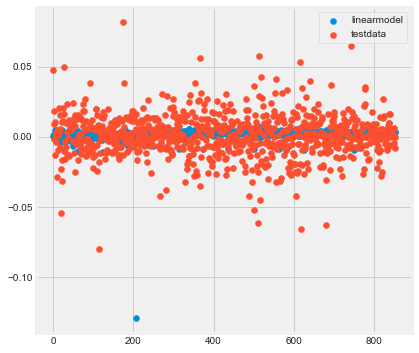

In [152]:
n = len(y_pred_linear)
plt.figure(figsize=(6,6))
plt.scatter(np.arange(n), y_pred_linear, label='linearmodel')
plt.scatter(np.arange(n),y_test, label='testdata')
plt.legend()

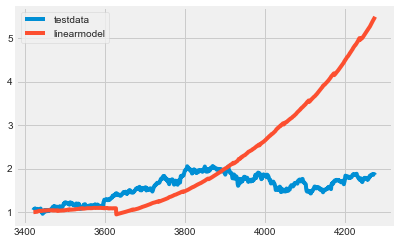

In [153]:
Linear_result = pd.DataFrame({'y_test':y_test,'y_pred':y_pred_linear})
Linear_result["Cumreturn_test"] = (Linear_result["y_test"]+1).cumprod()
Linear_result["Cumreturn_pred"] = (Linear_result["y_pred"]+1).cumprod()
Linear_result["Cumreturn_test"].plot(label='testdata')
Linear_result["Cumreturn_pred"].plot(label='linearmodel')
plt.legend()

Notice that the data has gone too far from the test data. In my opinion, the first half of the test data give the model a trend to go up, so it keeps going up and never turns down. 

Let us try Random Forest Regressor:

In [193]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators = 100,
                            max_depth = 500,
                            random_state = 100
                            )
regr.fit(x_train, y_train)
y_pred_rf = regr.predict(x_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf)
print(rmse_rf)

0.00027356411515933976


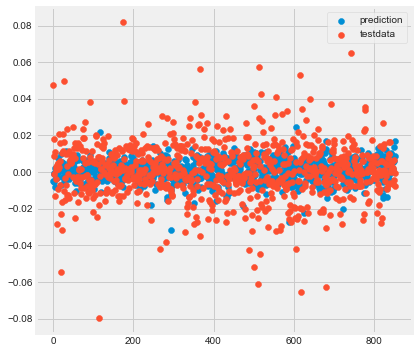

In [194]:
n = len(y_pred_rf)
plt.figure(figsize=(6,6))
plt.scatter(np.arange(n), y_pred_rf, label='prediction')
plt.scatter(np.arange(n),y_test, label='testdata')
plt.legend()

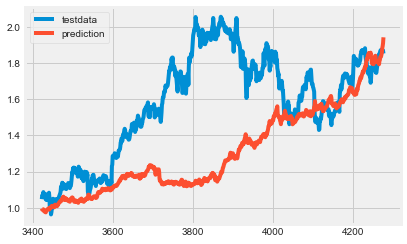

In [195]:
RandomForest_result = pd.DataFrame({'y_test':y_test,'y_pred':y_pred_rf})
RandomForest_result["Cumreturn_test"] = (RandomForest_result["y_test"]+1).cumprod()
RandomForest_result["Cumreturn_pred"] = (RandomForest_result["y_pred"]+1).cumprod()
RandomForest_result["Cumreturn_test"].plot(label='testdata')
RandomForest_result["Cumreturn_pred"].plot(label='prediction')
plt.legend()

The linear model gives a better rmse(though they are all inaccurate). However, the cummulative trend given by random forest regressor is a surpurising result, with almost the same end return as the test data. It avoids the exponantially blows up and keep reasonable all the way. But it cannot trace the daramatical change of the test data.

## Try LSTM First

Let us try LSTM first and see what does the result look like.

In [302]:
#scaling data
sc1 = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))

x_train_lstm = sc1.fit_transform(x_train)
x_test_lstm = sc1.transform(x_test)

y_train_ = np.array(y_train)
y_test_ = np.array(y_test)
y_train_lstm = sc2.fit_transform(y_train_.reshape(-1,1))
y_test_lstm = sc2.transform(y_test_.reshape(-1,1))

x_train_LSTM = np.reshape(np.array(x_train_lstm),(x_train_lstm.shape[0],x_train_lstm.shape[1],1))

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train_LSTM.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train_LSTM, y_train_lstm, batch_size=1, epochs=50)

x_test_LSTM = np.reshape(np.array(x_test), (x_test.shape[0], x_test.shape[1], 1))
y_pred_lstm = model.predict(x_test_LSTM)
y_pred_lstm = sc2.inverse_transform(y_pred_lstm)
y_pred_lstm = y_pred_lstm.reshape(-1,1)
y_test_ = np.array(y_test).reshape(-1,1)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((y_pred_lstm - y_test_) ** 2)))
rmse

Epoch 1/50
3419/3419 [==============================] - 21s 6ms/step - loss: 0.0095
Epoch 2/50
3419/3419 [==============================] - 20s 6ms/step - loss: 0.0080
Epoch 3/50
3419/3419 [==============================] - 19s 5ms/step - loss: 0.0079
Epoch 4/50
3419/3419 [==============================] - 19s 6ms/step - loss: 0.0078
Epoch 5/50
3419/3419 [==============================] - 19s 6ms/step - loss: 0.0078
Epoch 6/50
3419/3419 [==============================] - 19s 6ms/step - loss: 0.0078
Epoch 7/50
3419/3419 [==============================] - 19s 6ms/step - loss: 0.0078
Epoch 8/50
3419/3419 [==============================] - 19s 6ms/step - loss: 0.0077
Epoch 9/50
3419/3419 [==============================] - 19s 6ms/step - loss: 0.0077
Epoch 10/50
3419/3419 [==============================] - 19s 6ms/step - loss: 0.0078
Epoch 11/50
3419/3419 [==============================] - 19s 6ms/step - loss: 0.0077
Epoch 12/50
3419/3419 [==============================] - 19s 6ms/step - lo

0.015492600528834428

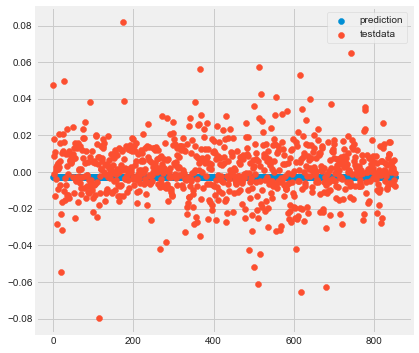

In [303]:
n = len(y_pred_lstm)
plt.figure(figsize=(6,6))
plt.scatter(np.arange(n), y_pred_lstm, label='prediction')
plt.scatter(np.arange(n),y_test_, label='testdata')
plt.legend()

It turns out that the LSTM just gave a line which is not we want. More features or epoches maybe help.

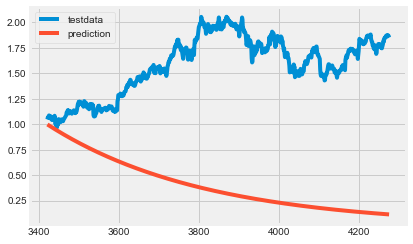

In [304]:
LSTM_result = pd.DataFrame({'y_test':y_test,'y_pred':y_pred_lstm.reshape(854)})
LSTM_result["Cumreturn_test"] = (LSTM_result["y_test"]+1).cumprod()
LSTM_result["Cumreturn_pred"] = (LSTM_result["y_pred"]+1).cumprod()
LSTM_result["Cumreturn_test"].plot(label='testdata')
LSTM_result["Cumreturn_pred"].plot(label='prediction')
plt.legend()

The result is really bad, I decided to add more features to our data.

## Create more features

The number of features right now is not enough to support either our baseline model or LSTM. Although financial time series can be viewed as a markov chain, it doesn't mean that we can treat it as a markov chain in machine learning. Historical data is worth noticing (a long interval). Thus, I would add more features like previous return, volatility and volume with rolling window can be traced back up to 60 days. 

In [550]:
data_features = data1.copy()

In [551]:
data_features['Logreturn_1d'] = np.log(data_features['Adj Close']/data_features['Adj Close'].shift(1))
data_features['Logreturn_1w']=pd.Series(data_features['Logreturn_1d']).rolling(window=5).sum()
data_features['Logreturn_2w']=pd.Series(data_features['Logreturn_1d']).rolling(window=10).sum()
data_features['Logreturn_3w']=pd.Series(data_features['Logreturn_1d']).rolling(window=15).sum()
data_features['Logreturn_4w']=pd.Series(data_features['Logreturn_1d']).rolling(window=20).sum()
data_features['Logreturn_8w']=pd.Series(data_features['Logreturn_1d']).rolling(window=40).sum()
data_features['Logreturn_12w']=pd.Series(data_features['Logreturn_1d']).rolling(window=60).sum()

data_features['Vol_1w']=pd.Series(data_features['Logreturn_1d']).rolling(window=5).std()*np.sqrt(5)
data_features['Vol_2w']=pd.Series(data_features['Logreturn_1d']).rolling(window=10).std()*np.sqrt(10)
data_features['Vol_3w']=pd.Series(data_features['Logreturn_1d']).rolling(window=15).std()*np.sqrt(15)
data_features['Vol_4w']=pd.Series(data_features['Logreturn_1d']).rolling(window=20).std()*np.sqrt(20)
data_features['Vol_8w']=pd.Series(data_features['Logreturn_1d']).rolling(window=40).std()*np.sqrt(40)
data_features['Vol_12w']=pd.Series(data_features['Logreturn_1d']).rolling(window=60).std()*np.sqrt(60)

data_features['Volume_1w']=pd.Series(data_features['Volume']).rolling(window=5).mean()
data_features['Volume_2w']=pd.Series(data_features['Volume']).rolling(window=10).mean()
data_features['Volume_3w']=pd.Series(data_features['Volume']).rolling(window=15).mean()
data_features['Volume_4w']=pd.Series(data_features['Volume']).rolling(window=20).mean()
data_features['Volume_8w']=pd.Series(data_features['Volume']).rolling(window=40).mean()
data_features['Volume_12w']=pd.Series(data_features['Volume']).rolling(window=60).mean()


In [552]:
data_features.drop(data_features.index[0:60], inplace=True)

In [553]:
data_features.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,SPY,...,Vol_3w,Vol_4w,Vol_8w,Vol_12w,Volume_1w,Volume_2w,Volume_3w,Volume_4w,Volume_8w,Volume_12w
count,4215.000000,4215.000000,4215.000000,4215.000000,4215.000000,4215.000000,4215.000000,4.215000e+03,4215.000000,4215.000000,...,4215.000000,4215.000000,4215.000000,4215.000000,4.215000e+03,4.215000e+03,4.215000e+03,4.215000e+03,4.215000e+03,4.215000e+03
mean,34.514991,171.292159,0.002028,1.001898,173.242451,169.270424,171.376776,1.297914e+08,0.001265,0.000247,...,0.089600,0.104685,0.152151,0.189118,1.298111e+08,1.298620e+08,1.299018e+08,1.299336e+08,1.300794e+08,1.302606e+08
std,36.779186,174.604361,0.031237,0.094942,176.129540,173.035603,174.724320,9.653001e+07,0.025141,0.012427,...,0.060658,0.068203,0.091161,0.107806,8.499295e+07,8.085071e+07,7.862182e+07,7.713083e+07,7.379778e+07,7.171932e+07
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06,-0.179195,-0.098448,...,0.014343,0.020359,0.053727,0.073040,1.891554e+07,2.425027e+07,2.506430e+07,2.561632e+07,3.076699e+07,3.225360e+07
25%,3.020100,38.330000,0.000000,1.000000,38.865000,37.839900,38.420000,6.329540e+07,-0.011108,-0.005079,...,0.056395,0.066696,0.098861,0.122515,6.653663e+07,6.776896e+07,6.895789e+07,7.041524e+07,7.249018e+07,7.484239e+07
50%,17.433100,105.990000,0.000000,1.000000,107.580000,104.880000,106.270000,1.015812e+08,0.000801,0.000649,...,0.076810,0.090086,0.135461,0.169811,1.063455e+08,1.096787e+08,1.107962e+08,1.096750e+08,1.106747e+08,1.135745e+08
75%,63.128550,235.422500,0.000000,1.000000,237.045000,229.948900,233.987500,1.685708e+08,0.013616,0.005905,...,0.107727,0.127395,0.175985,0.213088,1.710757e+08,1.723245e+08,1.710802e+08,1.723127e+08,1.712976e+08,1.721053e+08
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,8.432424e+08,0.139042,0.145198,...,0.814040,0.825419,0.849985,0.873629,5.824403e+08,4.995738e+08,4.806513e+08,4.697965e+08,4.088734e+08,3.668912e+08


In [554]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4215 entries, 61 to 4276
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dt             4215 non-null   object 
 1   Adj Close      4215 non-null   float64
 2   Close          4215 non-null   float64
 3   Div            4215 non-null   float64
 4   Factor         4215 non-null   float64
 5   High           4215 non-null   float64
 6   Low            4215 non-null   float64
 7   Open           4215 non-null   float64
 8   Volume         4215 non-null   float64
 9   Return         4215 non-null   float64
 10  SPY            4215 non-null   float64
 11  XLK            4215 non-null   float64
 12  Logreturn_1d   4215 non-null   float64
 13  Logreturn_1w   4215 non-null   float64
 14  Logreturn_2w   4215 non-null   float64
 15  Logreturn_3w   4215 non-null   float64
 16  Logreturn_4w   4215 non-null   float64
 17  Logreturn_8w   4215 non-null   float64
 18  Logretu

In [555]:
data_features.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,...,Vol_3w,Vol_4w,Vol_8w,Vol_12w,Volume_1w,Volume_2w,Volume_3w,Volume_4w,Volume_8w,Volume_12w
61,2000-03-30,3.9077,125.750,0.0,1.0,137.688,125.438,133.563,103600000.0,-0.074947,...,0.177359,0.185160,0.272557,0.353138,79164960.0,93693040.0,9.250957e+07,86318260.0,92695470.0,1.130021e+08
62,2000-03-31,4.2204,135.813,0.0,1.0,137.250,126.000,127.438,101158400.0,0.080021,...,0.191272,0.194835,0.279113,0.360582,77050960.0,96182800.0,9.511003e+07,87334100.0,92254470.0,1.114451e+08
63,2000-04-03,4.1427,133.313,0.0,1.0,139.500,129.438,135.500,82140800.0,-0.018411,...,0.188042,0.194874,0.277524,0.348280,79520000.0,99284640.0,9.552013e+07,88809140.0,91649740.0,1.096142e+08
64,2000-04-04,3.9562,127.313,0.0,1.0,133.000,116.750,132.625,165082400.0,-0.045019,...,0.183237,0.199466,0.277423,0.349561,102388160.0,102684680.0,9.938264e+07,93650620.0,93020130.0,1.104459e+08
65,2000-04-05,4.0514,130.375,0.0,1.0,132.875,124.000,126.469,114416400.0,0.024063,...,0.183729,0.200407,0.278192,0.349387,113279600.0,99926400.0,9.961691e+07,95981060.0,93326520.0,1.102484e+08


## Baseline Model with multiple features

Try linear regression and Random Forest again.

In [562]:
breakpoint = int(len(data_features)*0.8)
data_ = data_features.drop(['Dt'], axis=1)
x_train_f = data_[0:breakpoint-1]
x_test_f = data_[breakpoint:-1]
y_r_f = data_.iloc[0:breakpoint, 8].shift(-1)
y_t_f = data_.iloc[breakpoint:, 8].shift(-1)
y_train_f = y_r_f.drop(y_r_f.index[-1])
y_test_f = y_t_f.drop(y_t_f.index[-1])

In [563]:
pipe = Pipeline(steps=[('pca', PCA()), ('linear', LinearRegression())])
pipe.fit(x_train_f, y_train_f)
y_pred_linear_f = pipe.predict(x_test_f)
rmse_linear_f = mean_squared_error(y_test_f, y_pred_linear_f)
print(rmse_linear)

0.0002559157205788761


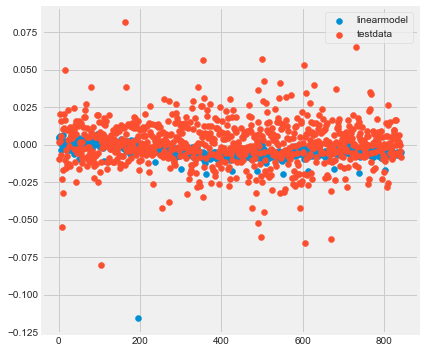

In [564]:
n = len(y_pred_linear_f)
plt.figure(figsize=(6,6))
plt.scatter(np.arange(n), y_pred_linear_f, label='linearmodel')
plt.scatter(np.arange(n),y_test_f, label='testdata')
plt.legend()

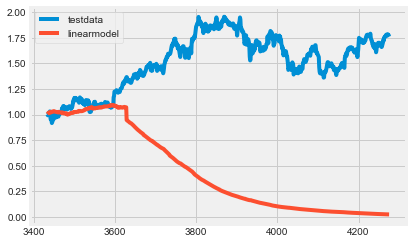

In [565]:
Linear_result = pd.DataFrame({'y_test':y_test_f,'y_pred':y_pred_linear_f})
Linear_result["Cumreturn_test"] = (Linear_result["y_test"]+1).cumprod()
Linear_result["Cumreturn_pred"] = (Linear_result["y_pred"]+1).cumprod()
Linear_result["Cumreturn_test"].plot(label='testdata')
Linear_result["Cumreturn_pred"].plot(label='linearmodel')
plt.legend()

The result is worse than less features linear regression. I was wondering what is going on at the day 200 in test data, which drags the line from going down.

Random Forest Regressor:

In [566]:
regr = RandomForestRegressor(n_estimators = 100,
                            max_depth = 500,
                            random_state = 100
                            )
regr.fit(x_train_f, y_train_f)
y_pred_rf_f = regr.predict(x_test_f)
rmse_rf_f = mean_squared_error(y_test_f, y_pred_rf_f)
print(rmse_rf_f)

0.000920185599968597


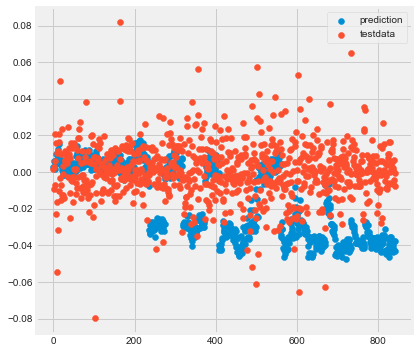

In [567]:
n = len(y_pred_rf_f)
plt.figure(figsize=(6,6))
plt.scatter(np.arange(n), y_pred_rf_f, label='prediction')
plt.scatter(np.arange(n),y_test_f, label='testdata')
plt.legend()

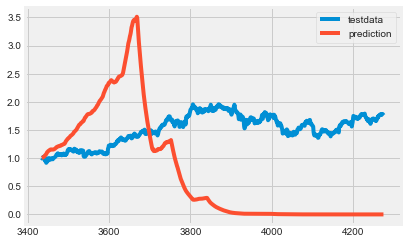

In [568]:
RandomForest_result = pd.DataFrame({'y_test':y_test_f,'y_pred':y_pred_rf_f})
RandomForest_result["Cumreturn_test"] = (RandomForest_result["y_test"]+1).cumprod()
RandomForest_result["Cumreturn_pred"] = (RandomForest_result["y_pred"]+1).cumprod()
RandomForest_result["Cumreturn_test"].plot(label='testdata')
RandomForest_result["Cumreturn_pred"].plot(label='prediction')
plt.legend()

Same things happen in random forest. I found that the dividend or factor feature may trigger this since it changed from 0 to 1 at day 200 in test data, which coincides the graph above.

Considering this situation, I decided to try LSTM first and then kicked out the features other than adjusted close.

In [569]:
#scaling data
sc1 = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))

x_train_lstm_f = sc1.fit_transform(x_train_f)
x_test_lstm_f = sc1.transform(x_test_f)

y_train_ = np.array(y_train_f)
y_test_ = np.array(y_test_f)
y_train_lstm_f = sc2.fit_transform(y_train_.reshape(-1,1))
y_test_lstm_f = sc2.transform(y_test_.reshape(-1,1))

In [570]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

x_train_LSTM_f = np.reshape(np.array(x_train_lstm_f),(x_train_lstm_f.shape[0],x_train_lstm_f.shape[1],1))

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train_LSTM_f.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 30, 50)            10400     
_________________________________________________________________
dropout_38 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 30, 50)            20200     
_________________________________________________________________
dropout_39 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_33 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_34 (Dense)             (None, 1)               

In [653]:

#Train the model
history = model.fit(x_train_LSTM_f, y_train_lstm_f, batch_size=16, epochs=30)

x_test_LSTM_f = np.reshape(np.array(x_test_f), (x_test_f.shape[0], x_test_f.shape[1], 1))
y_pred_lstm_f = model.predict(x_test_LSTM_f)
y_pred_lstm_f = sc2.inverse_transform(y_pred_lstm_f)
y_pred_lstm_f = y_pred_lstm_f.reshape(-1,1)
y_test_f_ = np.array(y_test_f).reshape(-1,1)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((y_pred_lstm_f - y_test_f_) ** 2)))
rmse

Epoch 1/300
180/211 [========================>.....] - ETA: 0s - loss: 0.0073

KeyboardInterrupt: 

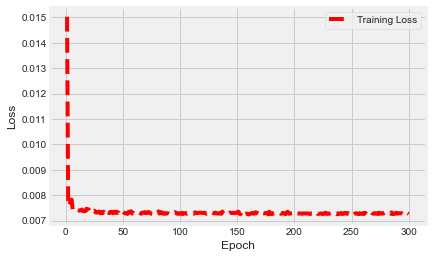

In [573]:
# Get training and test loss histories
training_loss = history.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

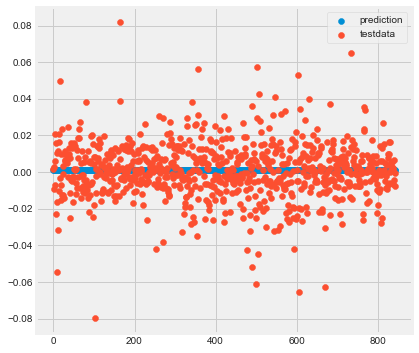

In [574]:
n = len(y_pred_lstm_f)
plt.figure(figsize=(6,6))
plt.scatter(np.arange(n), y_pred_lstm_f, label='prediction')
plt.scatter(np.arange(n),y_test_f_, label='testdata')
plt.legend()

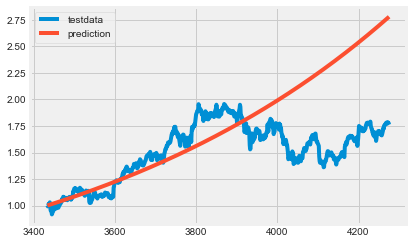

In [576]:
LSTM_result = pd.DataFrame({'y_test':y_test_f,'y_pred':y_pred_lstm_f.reshape(842)})
LSTM_result["Cumreturn_test"] = (LSTM_result["y_test"]+1).cumprod()
LSTM_result["Cumreturn_pred"] = (LSTM_result["y_pred"]+1).cumprod()
LSTM_result["Cumreturn_test"].plot(label='testdata')
LSTM_result["Cumreturn_pred"].plot(label='prediction')
plt.legend()

Although a 300-epoch LSTM is used, the reslt is nnot satisfying. I wonder what is going on in the model, so I try to observe the prediction out of the training set.

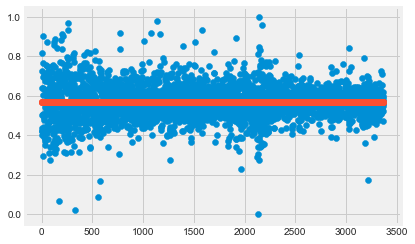

In [577]:
train_predict = model.predict(x_train_LSTM_f)
x = np.arange(len(train_predict))

plt.scatter(x, y_train_lstm_f)
plt.scatter(x, train_predict)

That is totally insane. I think the choice of making the return as target is not correct. So I decided to

## Make some changes

This part only contains the adjusted close and its history adjusted close. I add the past 20 days (4 weeks) data of day t-1 to the row t-1 and use them to predict a t day adjusted close. Let's go!

In [578]:
data_less = data1[['Adj Close']]
breakpoint = int(len(data_less)*0.8)
train_data = data_less[0:breakpoint]
test_data = data_less[breakpoint:]

sc3 = MinMaxScaler(feature_range=(0,1))
sc4 = MinMaxScaler(feature_range=(0,1))

train_scaled = sc3.fit_transform(train_data)

x_train_less = []
y_train_less = []

#select the past 20 day adjusted close price as feature

for i in range(20,breakpoint):
    x_train_less.append(train_scaled[i-20:i, 0])
    y_train_less.append(train_scaled[i,0])
x_train_less, y_train_less = np.array(x_train_less),np.array(y_train_less)

In [579]:
x_train_less = np.reshape(x_train_less, (x_train_less.shape[0],x_train_less.shape[1],1))

In [580]:

model_lstm = Sequential()
model_lstm.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train_less.shape[1],1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units = 50,return_sequences = True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units = 50,return_sequences = True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units = 50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units = 1))
model_lstm.compile(optimizer = 'adam',loss = 'mean_squared_error')

print(model_lstm.summary())


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 20, 50)            10400     
_________________________________________________________________
dropout_40 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
dropout_41 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
dropout_42 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 50)              

In [581]:
history_adj = model_lstm.fit(x_train_less,y_train_less,epochs = 10, batch_size = 16)

Epoch 1/10
213/213 [==============================] - 5s 22ms/step - loss: 0.0050
Epoch 2/10
213/213 [==============================] - 5s 21ms/step - loss: 0.0018
Epoch 3/10
213/213 [==============================] - 5s 21ms/step - loss: 0.0016
Epoch 4/10
213/213 [==============================] - 5s 21ms/step - loss: 0.0015
Epoch 5/10
213/213 [==============================] - 5s 22ms/step - loss: 0.0013
Epoch 6/10
213/213 [==============================] - 5s 22ms/step - loss: 0.0011
Epoch 7/10
213/213 [==============================] - 5s 22ms/step - loss: 0.0015
Epoch 8/10
213/213 [==============================] - 5s 22ms/step - loss: 0.0011
Epoch 9/10
213/213 [==============================] - 5s 21ms/step - loss: 0.0011
Epoch 10/10
213/213 [==============================] - 5s 22ms/step - loss: 0.0010


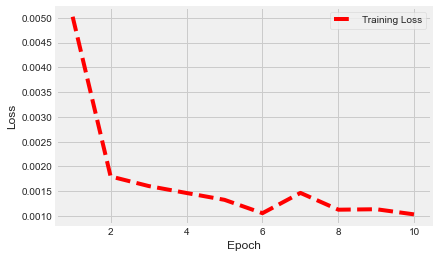

In [583]:
# Get training and test loss histories
training_loss = history_adj.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [584]:
inputs = data_less[len(data_less) - len(test_data)-20:].values

In [585]:
inputs = inputs.reshape(-1,1)
inputs = sc3.transform(inputs)
inputs.shape

(875, 1)

In [586]:
x_test_less = []
for i in range(20,len(test_data)):
    x_test_less.append(inputs[i-20:i,0])
x_test_less = np.array(x_test_less)
x_test_less.shape

(835, 20)

In [587]:
x_test_less = np.reshape(x_test_less, (x_test_less.shape[0],x_test_less.shape[1],1))

In [588]:
# inverse the scaling and compare to the actual return
predicted_price = model_lstm.predict(x_test_less)
predicted_price = sc3.inverse_transform(predicted_price)

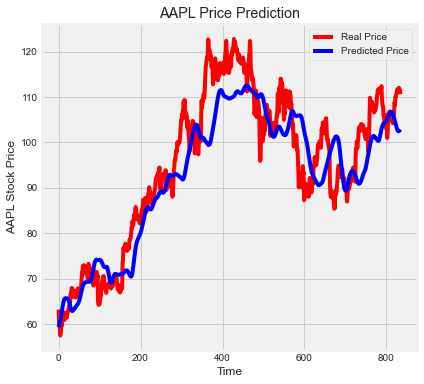

In [589]:
plt.figure(figsize=(6,6))
x_ = np.arange(len(test_data)-20)
plt.plot(x_, test_data[20:], color = 'red', label = 'Real Price')
plt.plot(x_, predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('AAPL Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

Wow! The restult is amazing, proving that setting adjusted close as the target is definitely a good choice. However, there is a time lag between the real price and predicted price. It is somehow "useless" to get the predicted price after knowing the actual price.

What cause this? The reason is that the neural network will always mimic the movement you gave it. A 20 days data can make it mimic the price movement within the 20 days but not the next day. 

Our goal is making the machine learn how to predict the next day price using the past data. So the features must contain the information of past days but not giving the adjusted price directly. This makes me think of the features I create above. 

Why don't we use those features and set adjusted close as target but not the return. Let's explore and build a better LSTM model.

## Keep the Adj Close and create more features

In [590]:
breakpoint = int(len(data_features)*0.8)
data_ = data_features.drop(['Dt','Close','Div','Factor','High','Low','Open','Volume','Return'], axis=1)
#data_.drop(['Volume_1w','Volume_2w'],axis=1,inplace = True)
x_train_a = data_[0:breakpoint-1]
x_test_a = data_[breakpoint:-1]
y_r_a = data_.iloc[0:breakpoint, 0].shift(-1)
y_t_a = data_.iloc[breakpoint:, 0].shift(-1)
y_train_a = y_r_a.drop(y_r_a.index[-1])
y_test_a = y_t_a.drop(y_t_a.index[-1])

In [591]:
data2 = data_
breakpoint = int(len(data2)*0.8)
train_data_2 = data2[0:breakpoint]
test_data_2 = data2[breakpoint:]

# Min Max Scaling
mms = MinMaxScaler(feature_range=(0,1))

train_scaled_2 = mms.fit_transform(train_data_2)

In [597]:
y_train_2 = train_scaled_2[1:,0]

x_train_2 = train_scaled_2[0:-1]

x_train_2 = np.reshape(x_train_2, (x_train_2.shape[0],x_train_2.shape[1],1))

In [598]:

model_lstm_2 = Sequential()
model_lstm_2.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train_2.shape[1],1)))
model_lstm_2.add(Dropout(0.2))
model_lstm_2.add(LSTM(units = 50,return_sequences = True))
model_lstm_2.add(Dropout(0.2))
model_lstm_2.add(LSTM(units = 50,return_sequences = True))
model_lstm_2.add(Dropout(0.2))
model_lstm_2.add(LSTM(units = 50))
model_lstm_2.add(Dropout(0.2))
model_lstm_2.add(Dense(units = 1))
model_lstm_2.compile(optimizer = 'adam',loss = 'mean_squared_error')

print(model_lstm_2.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 22, 50)            10400     
_________________________________________________________________
dropout_44 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 22, 50)            20200     
_________________________________________________________________
dropout_45 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 22, 50)            20200     
_________________________________________________________________
dropout_46 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 50)              

In [611]:
history_lstm2 = model_lstm_2.fit(x_train_2,y_train_2,epochs = 50, batch_size = 16)

Epoch 1/50
211/211 [==============================] - 5s 24ms/step - loss: 0.0012
Epoch 2/50
211/211 [==============================] - 5s 26ms/step - loss: 9.8281e-04
Epoch 3/50
211/211 [==============================] - 5s 26ms/step - loss: 0.0011
Epoch 4/50
211/211 [==============================] - 5s 25ms/step - loss: 0.0010
Epoch 5/50
211/211 [==============================] - 5s 23ms/step - loss: 8.9295e-04
Epoch 6/50
211/211 [==============================] - 5s 22ms/step - loss: 0.0011
Epoch 7/50
211/211 [==============================] - 5s 22ms/step - loss: 0.0011
Epoch 8/50
211/211 [==============================] - 5s 23ms/step - loss: 9.5612e-04
Epoch 9/50
211/211 [==============================] - 5s 23ms/step - loss: 9.6378e-04
Epoch 10/50
211/211 [==============================] - 5s 22ms/step - loss: 8.3252e-04
Epoch 11/50
211/211 [==============================] - 5s 23ms/step - loss: 8.5147e-04
Epoch 12/50
211/211 [==============================] - 5s 22ms/step - lo

In [617]:
inputs_2 = mms.transform(test_data_2)
inputs_2.shape

(843, 22)

In [620]:
x_test_2 = inputs_2[0:-1]
y_test_2 = inputs_2[1:,0]

x_test_2 = np.reshape(x_test_2, (x_test_2.shape[0],x_test_2.shape[1],1))

predicted_price_2 = model_lstm_2.predict(x_test_2)

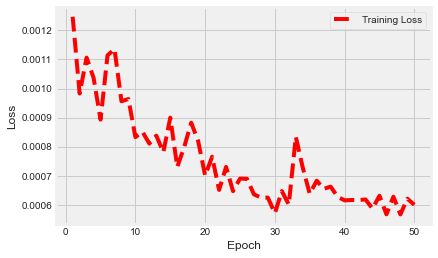

In [654]:
# Get training and test loss histories
training_loss = history_lstm2.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

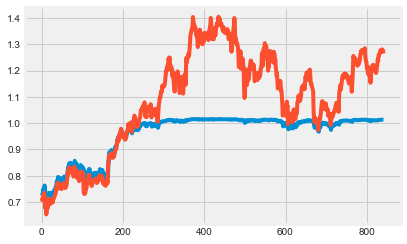

In [621]:
x = np.arange(len(test_data_2)-1)
plt.plot(x,predicted_price_2)
plt.plot(x,y_test_2)

The first quarter of the result is amazing. However, when the stock price of Apple started to take off, the model couldn't catch it. After googling it, I found that it is because of the large number of features and relatively short samples. So I decided to delete some features and cut the rolling day up to 2 weeks (10 days).

In [639]:
data_features = data1.copy()
data_features['Logreturn_1d'] = np.log(data_features['Adj Close']/data_features['Adj Close'].shift(1))
data_features['Logreturn_1w']=pd.Series(data_features['Logreturn_1d']).rolling(window=5).sum()
data_features['Logreturn_2w']=pd.Series(data_features['Logreturn_1d']).rolling(window=10).sum()

data_features['Vol_1w']=pd.Series(data_features['Logreturn_1d']).rolling(window=5).std()*np.sqrt(5)
data_features['Vol_2w']=pd.Series(data_features['Logreturn_1d']).rolling(window=10).std()*np.sqrt(10)

data_features['Volume_1w']=pd.Series(data_features['Volume']).rolling(window=5).mean()
data_features['Volume_2w']=pd.Series(data_features['Volume']).rolling(window=10).mean()
data_features.drop(data_features.index[0:20], inplace=True)

In [640]:
breakpoint = int(len(data_features)*0.8)
data_ = data_features.drop(['Dt','Close','Div','Factor','High','Low','Open','Volume','Return'], axis=1)
#data_.drop(['Volume_1w','Volume_2w'],axis=1,inplace = True)
x_train_a = data_[0:breakpoint-1]
x_test_a = data_[breakpoint:-1]
y_r_a = data_.iloc[0:breakpoint, 0].shift(-1)
y_t_a = data_.iloc[breakpoint:, 0].shift(-1)
y_train_a = y_r_a.drop(y_r_a.index[-1])
y_test_a = y_t_a.drop(y_t_a.index[-1])

In [641]:
data2 = data_
breakpoint = int(len(data2)*0.8)
train_data_2 = data2[0:breakpoint]
test_data_2 = data2[breakpoint:]

# Min Max Scaling
mms = MinMaxScaler(feature_range=(0,1))

train_scaled_2 = mms.fit_transform(train_data_2)

In [642]:
y_train_2 = train_scaled_2[1:,0]

x_train_2 = train_scaled_2[0:-1]

x_train_2 = np.reshape(x_train_2, (x_train_2.shape[0],x_train_2.shape[1],1))

In [708]:

model_lstm_3 = Sequential()
model_lstm_3.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train_2.shape[1],1)))
model_lstm_3.add(Dropout(0.2))
model_lstm_3.add(LSTM(units = 50,return_sequences = True))
model_lstm_3.add(Dropout(0.2))
model_lstm_3.add(LSTM(units = 50,return_sequences = True))
model_lstm_3.add(Dropout(0.2))
model_lstm_3.add(LSTM(units = 50))
model_lstm_3.add(Dropout(0.2))
model_lstm_3.add(Dense(units = 1))
model_lstm_3.compile(optimizer = 'adam',loss = 'mean_squared_error')

print(model_lstm_3.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 10, 50)            10400     
_________________________________________________________________
dropout_58 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_80 (LSTM)               (None, 10, 50)            20200     
_________________________________________________________________
dropout_59 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_81 (LSTM)               (None, 10, 50)            20200     
_________________________________________________________________
dropout_60 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 50)              

In [709]:
history_lstm3 = model_lstm_3.fit(x_train_2,y_train_2,epochs = 50, batch_size = 16)

Epoch 1/50
213/213 [==============================] - 3s 13ms/step - loss: 0.0309
Epoch 2/50
213/213 [==============================] - 3s 13ms/step - loss: 0.0058
Epoch 3/50
213/213 [==============================] - 3s 13ms/step - loss: 0.0045
Epoch 4/50
213/213 [==============================] - 3s 12ms/step - loss: 0.0042
Epoch 5/50
213/213 [==============================] - 3s 13ms/step - loss: 0.0031
Epoch 6/50
213/213 [==============================] - 3s 12ms/step - loss: 0.0032
Epoch 7/50
213/213 [==============================] - 3s 12ms/step - loss: 0.0029
Epoch 8/50
213/213 [==============================] - 3s 13ms/step - loss: 0.0028
Epoch 9/50
213/213 [==============================] - 3s 12ms/step - loss: 0.0028
Epoch 10/50
213/213 [==============================] - 3s 12ms/step - loss: 0.0021
Epoch 11/50
213/213 [==============================] - 3s 12ms/step - loss: 0.0022
Epoch 12/50
213/213 [==============================] - 3s 12ms/step - loss: 0.0021
Epoch 13/50
2

In [714]:
inputs_2 = mms.transform(test_data_2)
inputs_2.shape

(851, 10)

In [715]:
x_test_2 = inputs_2[0:-1]
y_test_2 = inputs_2[1:,0]

x_test_2 = np.reshape(x_test_2, (x_test_2.shape[0],x_test_2.shape[1],1))

predicted_price_2 = model_lstm_3.predict(x_test_2)

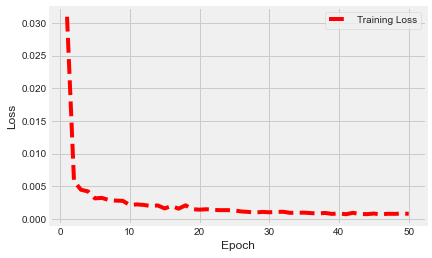

In [716]:
# Get training and test loss histories
training_loss = history_lstm3.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

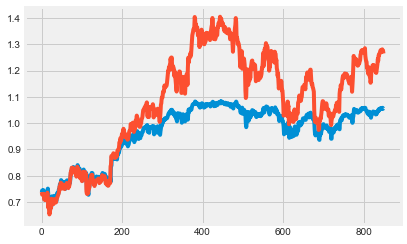

In [717]:
x = np.arange(len(test_data_2)-1)
plt.plot(x,predicted_price_2)
plt.plot(x,y_test_2)

I found that too much lstm layer may cause the model hard to learn, so I decided to reduce some layer and make the model simpler.

In [718]:

model_lstm_final = Sequential()
model_lstm_final.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train_2.shape[1],1)))
model_lstm_final.add(Dropout(0.2))
model_lstm_final.add(LSTM(units = 50))
model_lstm_final.add(Dropout(0.2))
model_lstm_final.add(Dense(units = 1))
model_lstm_final.compile(optimizer = 'adam',loss = 'mean_squared_error')

print(model_lstm_final.summary())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 10, 50)            10400     
_________________________________________________________________
dropout_62 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_63 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


In [719]:
history_lstm3 = model_lstm_final.fit(x_train_2,y_train_2,epochs = 50, batch_size = 16)

Epoch 1/50
213/213 [==============================] - 1s 6ms/step - loss: 0.0330
Epoch 2/50
213/213 [==============================] - 1s 7ms/step - loss: 0.0085
Epoch 3/50
213/213 [==============================] - 1s 6ms/step - loss: 0.0059
Epoch 4/50
213/213 [==============================] - 1s 6ms/step - loss: 0.0042
Epoch 5/50
213/213 [==============================] - 1s 6ms/step - loss: 0.0034
Epoch 6/50
213/213 [==============================] - 1s 6ms/step - loss: 0.0031
Epoch 7/50
213/213 [==============================] - 1s 7ms/step - loss: 0.0025
Epoch 8/50
213/213 [==============================] - 1s 6ms/step - loss: 0.0023
Epoch 9/50
213/213 [==============================] - 1s 6ms/step - loss: 0.0023
Epoch 10/50
213/213 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 11/50
213/213 [==============================] - 1s 6ms/step - loss: 0.0019
Epoch 12/50
213/213 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 13/50
213/213 [====

In [720]:
predicted_price_final = model_lstm_final.predict(x_test_2)

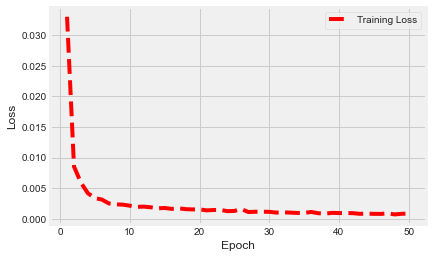

In [722]:
# Get training and test loss histories
training_loss = history_lstm3.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

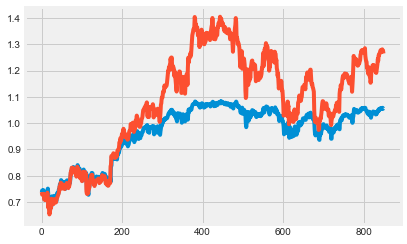

In [723]:
x = np.arange(len(test_data_2)-1)
plt.plot(x,predicted_price_2)
plt.plot(x,y_test_2)

In [736]:
adjclose = predicted_price_final.reshape(len(predicted_price_final)).tolist()
p = []
for i in range(1,len(adjclose)):
    p.append((adjclose[i]-adjclose[i-1])/adjclose[i-1])


In [737]:
p

[0.008658982344736287,
 0.013142642045156125,
 -0.013532522105326407,
 0.022069839563173144,
 -0.01056582995951417,
 -0.004157203659196865,
 -0.035406044994240556,
 0.028881312081658447,
 -0.0016101023510061215,
 -0.01188362989881672,
 0.01260669988713412,
 0.014677057731882368,
 -0.010312539211175708,
 0.0023114000565241854,
 0.02184635298308819,
 -0.014901371685677225,
 -0.04391456754959606,
 -0.010778094185214722,
 -0.0008413778321031271,
 -0.014789190128846916,
 -0.004049562746518285,
 0.019072527323604864,
 -0.0033244946225331976,
 -0.012330428056881523,
 0.03052652418680383,
 0.008864931812713882,
 -0.013680555637801331,
 0.015928679969270675,
 -0.016889156945283878,
 -0.005496661796431498,
 0.031045573573955272,
 -0.00631133948214354,
 -0.01726962365865538,
 0.019853092773779543,
 -0.014585543219529555,
 -0.009027843203115293,
 0.021967289799302504,
 0.03258337163824379,
 -0.01449383222603752,
 0.002645039550971766,
 -0.010249815191975297,
 0.03464929119110751,
 -0.0039672887593